In [1]:
! pip install -e ..

Obtaining file:///home/massimiliano/Projects/fl-g13
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for fl_g13 (pyproject.toml) ... done
  Created wheel for fl_g13: filename=fl_g13-0.0.1-py3-none-any.whl size=4584 sha256=425bdc6ef9a2e4703c1fd96dd46866d2d2c5d503d6f83d2b79639a9dd5792236
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2_3ta8k/wheels/ba/e6/76/85624c1c92362af95a88fb73ca068d24e3e74626054ee5ff32
Successfully built fl_g13
  Attempting uninstall: fl_g13
    Found existing installation: fl_g13 0.0.1
    Uninstalling fl_g13-0.0.1:
      Successfully uninstalled fl_g13-0.0.1


In [2]:
from fl_g13.fl_pytorch.client_app import get_client_app
from fl_g13.fl_pytorch.server_app import get_server_app
from fl_g13.fl_pytorch.model import get_experiment_setting, Net
from fl_g13.architectures import BaseDino
from flwr.simulation import run_simulation
from fl_g13.fl_pytorch.constants import (
    NUM_CLIENTS, 
    DEFAULT_FRACTION_FIT, 
    DEFAULT_NUM_ROUNDS, 
    DEFAULT_LOCAL_EPOCHS, 
    BATCH_SIZE,
    NUM_SHARDS_PER_PARTITION,
    DEFAULT_FRACTION_EVALUATE,
    MIN_NUM_CLIENTS
)

2025-05-08 18:39:09.853 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
DEBUG = True

number_of_rounds = DEFAULT_NUM_ROUNDS
fraction_fit = DEFAULT_FRACTION_FIT
fraction_evaluate = DEFAULT_FRACTION_EVALUATE
number_of_clients = NUM_CLIENTS
min_num_clients = MIN_NUM_CLIENTS
show_distribution = False
local_epochs = DEFAULT_LOCAL_EPOCHS
batch_size = BATCH_SIZE
num_shards_per_partition = NUM_SHARDS_PER_PARTITION
use_wandb = True
model_class = BaseDino

if DEBUG:
    number_of_rounds = 2
    fraction_fit = 1
    number_of_clients = 3
    min_num_clients = 3
    show_distribution = True
    local_epochs = 2
    batch_size = 128
    num_shards_per_partition = 6
    use_wandb = False
    model_class = BaseDino

In [4]:
checkpoint_dir = "./../models/"

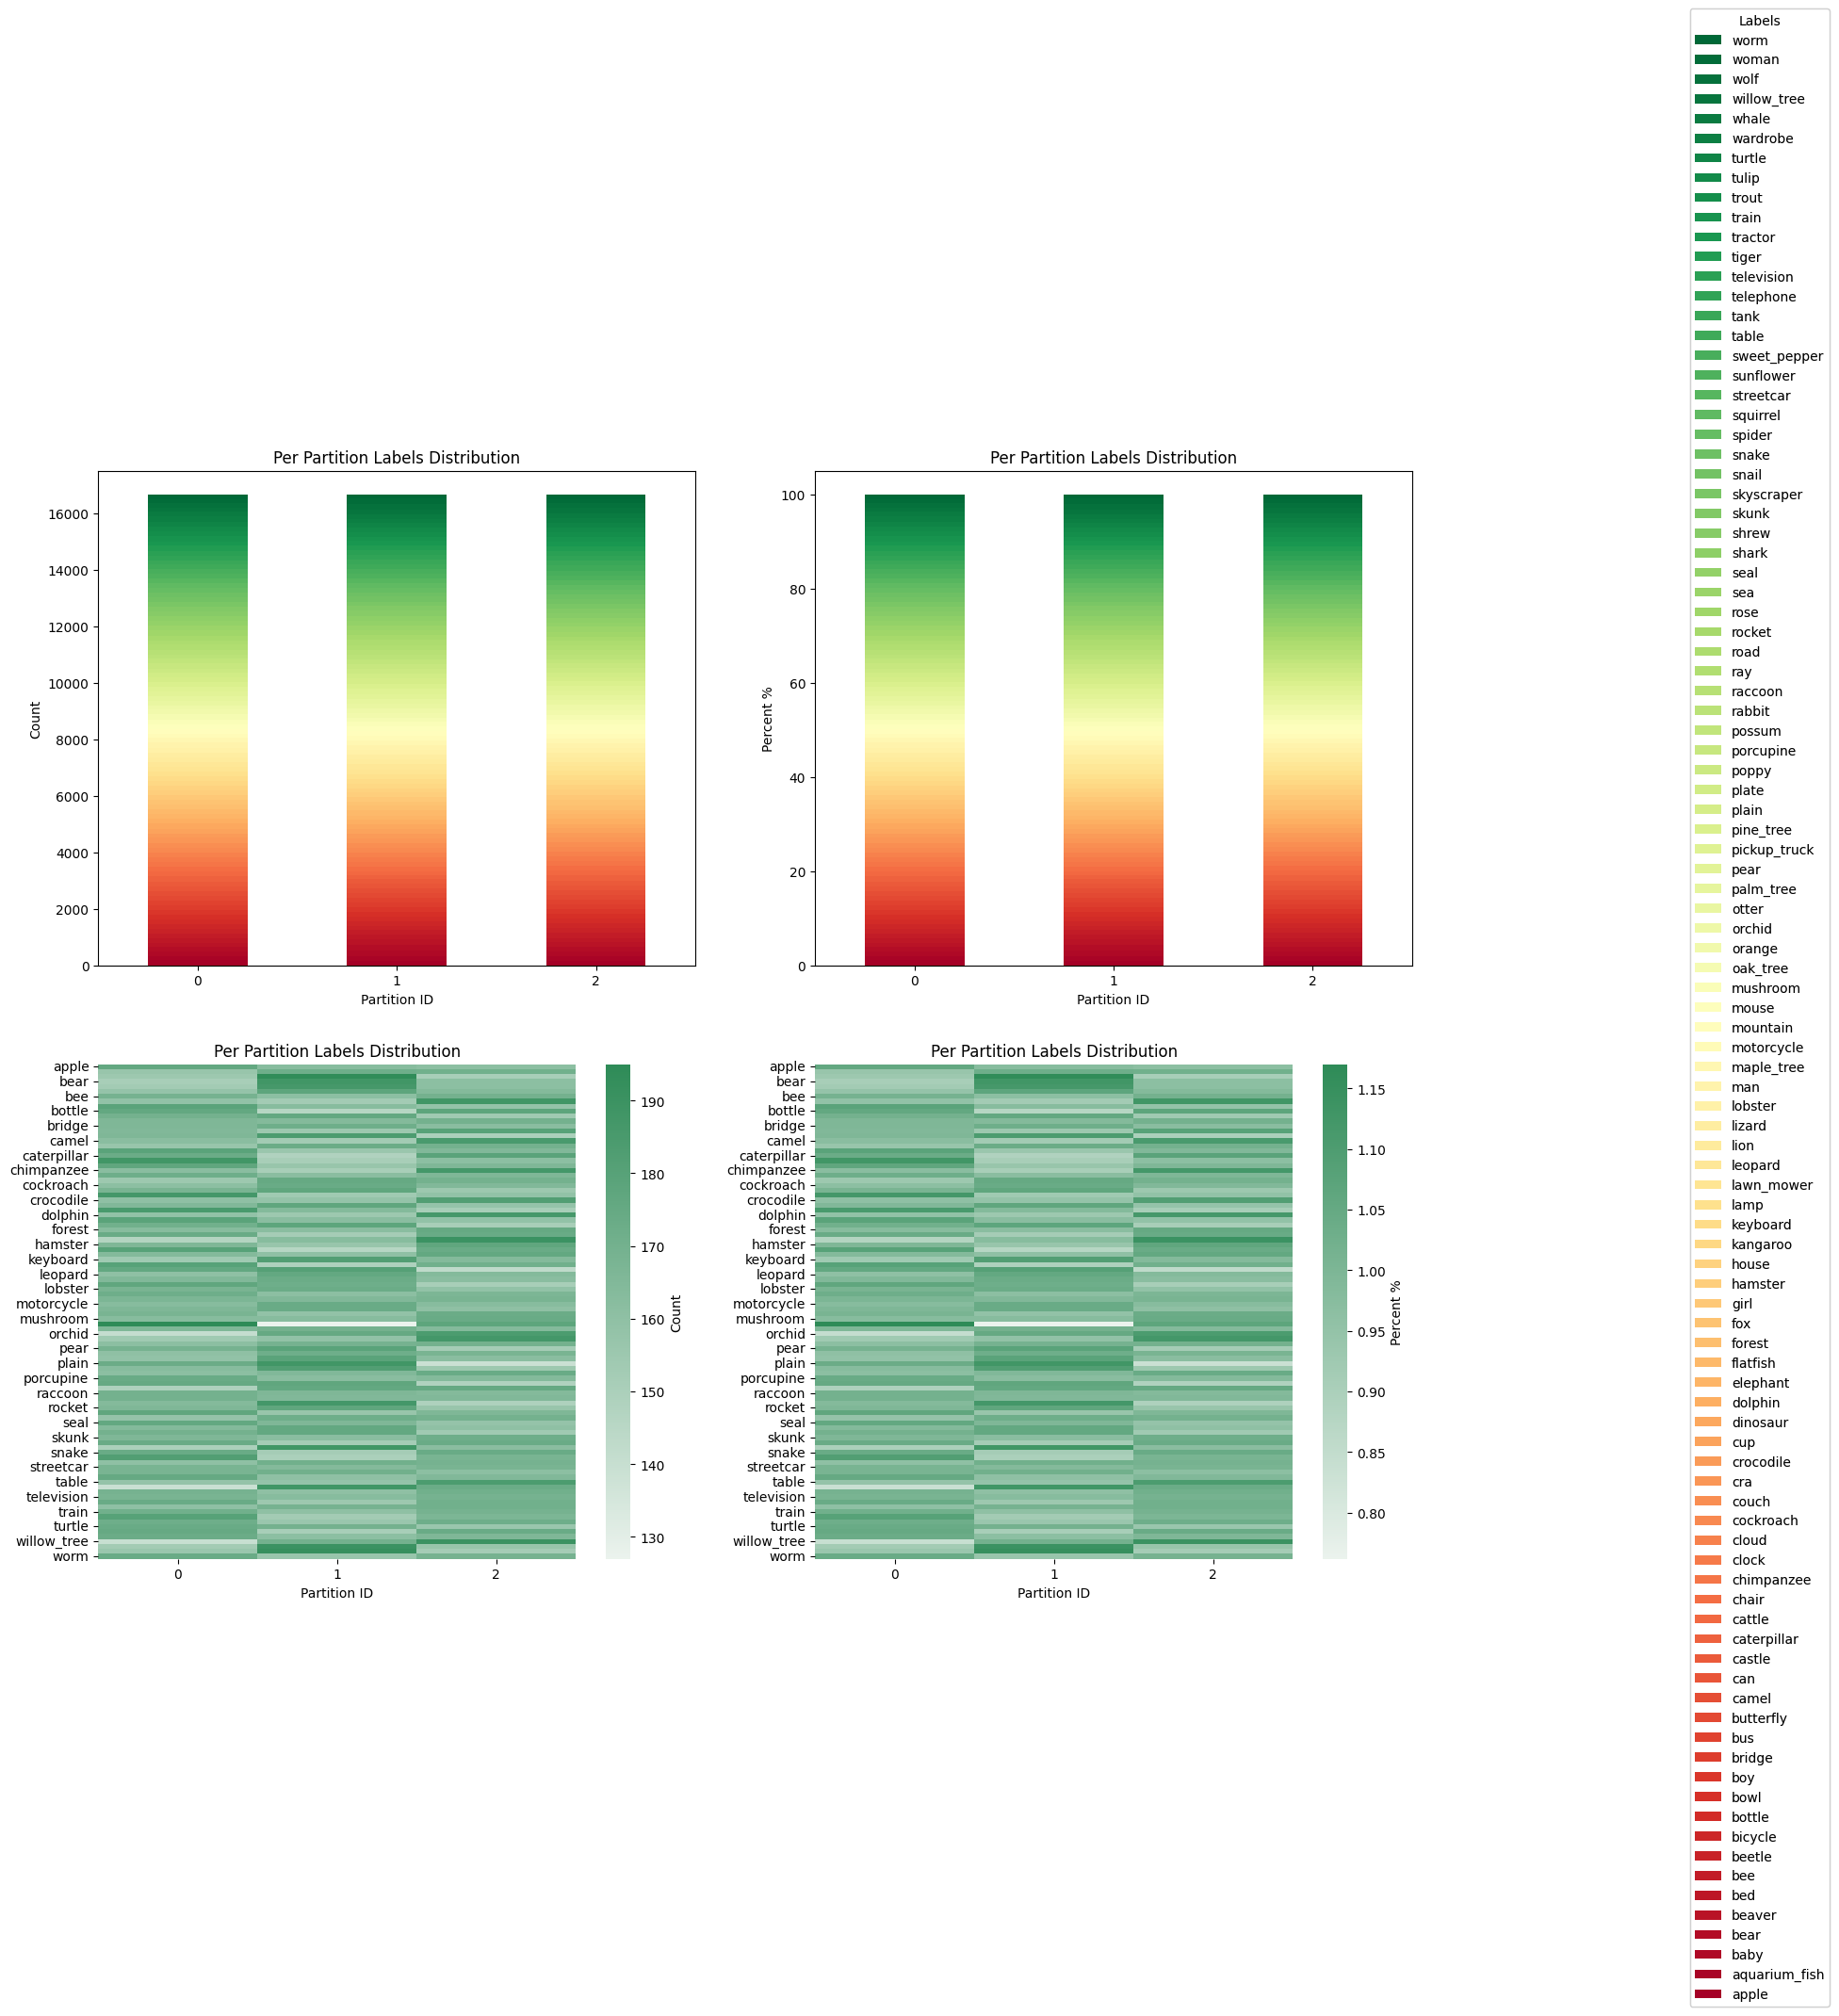

In [5]:
from flwr_datasets import FederatedDataset, partitioner
from fl_g13.fl_pytorch.datasets import show_partition_distribution
    
if show_distribution:
    fds = FederatedDataset(
            dataset="cifar100",
            partitioners={"train": partitioner.IidPartitioner(num_partitions=number_of_clients)}
        )
    p = fds.partitioners["train"]
    show_partition_distribution(p)

In [6]:
starting_lr = 0.001
partition_type = "iid" # or "shard"
momentum = 0.9
wandb_config = {
    "partition_type": partition_type,
    "starting_lr": starting_lr,
    "momentum": momentum,
}

In [7]:
model, optimizer, criterion, device, scheduler = get_experiment_setting(checkpoint_dir, model_class, starting_lr, momentum)
client_app = get_client_app(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    device=device, 
    partition_type=partition_type, 
    local_epochs=local_epochs,
    batch_size=batch_size,
    num_shards_per_partition=num_shards_per_partition,
    scheduler=scheduler,
)
server_app = get_server_app(
    model_class=model_class, 
    optimizer=optimizer, 
    criterion=criterion, 
    device=device, 
    num_rounds=number_of_rounds, 
    min_available_clients=number_of_clients,
    min_fit_clients=min_num_clients,
    min_evaluate_clients=min_num_clients,
    checkpoint_dir=checkpoint_dir,
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    use_wandb=use_wandb,
    wandb_config=wandb_config,
    scheduler=scheduler,
)

Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


⚠️ No checkpoint found at ./../models/. Creating a new model.


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


In [8]:
import os
import urllib.request


def download_if_not_exists(file_path: str, file_url: str):
    """
    Checks if a file exists at the given path. If it does not, downloads it from the specified URL.

    Parameters:
    - file_path (str): The local path to check and save the file.
    - file_url (str): The URL from which to download the file.
    """
    if not os.path.exists(file_path):
        print(f"'{file_path}' not found. Downloading from {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
            print("Download complete.")
        except Exception as e:
            print(f"Failed to download file: {e}")
    else:
        print(f"'{file_path}' already exists.")

In [9]:
download_if_not_exists("vision_transformer.py",
                       "https://raw.githubusercontent.com/facebookresearch/dino/refs/heads/main/vision_transformer.py")
download_if_not_exists("utils.py",
                       "https://raw.githubusercontent.com/facebookresearch/dino/refs/heads/main/utils.py")


'vision_transformer.py' already exists.
'utils.py' already exists.


In [10]:
import torch
import flwr

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cuda
Flower 1.17.0 / PyTorch 2.6.0+cu124


In [11]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config["client_resources"] = {"num_cpus": 1, "num_gpus": 1}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [12]:
run_simulation(
    client_app=client_app,
    server_app=server_app,
    num_supernodes=number_of_clients,
    backend_config=backend_config,
)

Continue train model from epoch 1


INFO :      Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
Eval progress: 100%|██████████| 313/313 [00:24<00:00, 13.04batch/s]
INFO :      ROUND 0💡 New best global model found: 0.009500
INFO :      initial parameters (loss, other metrics): 4.821795137545553, {'centralized_accuracy': 0.0095}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server round 0 - loss: 4.821795137545553, metrics: {'centralized_accuracy': 0.0095}


(ClientAppActor pid=105088) 2025-05-08 18:39:50.377 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13
Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) No prefix/name for the model was provided, choosen prefix/name: wacky_blastoise_12
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 1/2 (50.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.6534
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.13%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 48.01s | ETA: 48.01s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:40
(ClientAppActor pid=105088) 


Training progress: 100%|██████████| 105/105 [00:48<00:00,  2.15batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 2/2 (100.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.6029
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.19%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 48.92s | ETA: 0.00s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:41
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) No prefix/name for the model was provided, choosen prefix/name: sleepy_pidgey_98
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 1/2 (50.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.6529
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.09%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 49.61s | ETA: 49.61s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:42
(ClientAppActor pid=105088) 


Training progress: 100%|██████████| 105/105 [00:49<00:00,  2.11batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 2/2 (100.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.6053
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.31%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 49.77s | ETA: 0.00s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:43
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) No prefix/name for the model was provided, choosen prefix/name: groovy_beedrill_25
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 1/2 (50.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.6533
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.16%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 47.61s | ETA: 47.61s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:44
(ClientAppActor pid=105088) 


Training progress: 100%|██████████| 105/105 [00:47<00:00,  2.21batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 2/2 (100.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.6036
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.21%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 47.50s | ETA: 0.00s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:44
(ClientAppActor pid=105088) 


INFO :      aggregate_fit: received 3 results and 0 failures


[Round 1] Avg Client Drift: 0.6744
[Round 1] Relative Client Drift: 0.0013
Saving centralized model epoch 1 aggregated_parameters...
💾 Saved checkpoint at: ./../models/FL_BaseDino_epoch_1.pth


Eval progress: 100%|██████████| 313/313 [00:23<00:00, 13.42batch/s]
INFO :      ROUND 1💡 New best global model found: 0.014100
INFO :      fit progress: (1, 4.6126705998429856, {'centralized_accuracy': 0.0141}, 324.57980157500424)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Server round 1 - loss: 4.6126705998429856, metrics: {'centralized_accuracy': 0.0141}


Eval progress: 100%|██████████| 27/27 [00:08<00:00,  3.10batch/s]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) No prefix/name for the model was provided, choosen prefix/name: quirky_butterfree_66
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 1/2 (50.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.5895
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.67%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 48.24s | ETA: 48.24s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:46
(ClientAppActor pid=105088) 


Training progress: 100%|██████████| 105/105 [00:48<00:00,  2.17batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 2/2 (100.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.5446
(ClientAppActor pid=105088) 	✅ Training Accuracy: 2.34%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 48.29s | ETA: 0.00s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:47
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) No prefix/name for the model was provided, choosen prefix/name: itchy_pidgeot_68
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 1/2 (50.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.5868
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.73%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 47.30s | ETA: 47.30s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:48
(ClientAppActor pid=105088) 


Training progress: 100%|██████████| 105/105 [00:47<00:00,  2.22batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 2/2 (100.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.5446
(ClientAppActor pid=105088) 	✅ Training Accuracy: 2.38%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 47.35s | ETA: 0.00s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:48
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) No prefix/name for the model was provided, choosen prefix/name: grumpy_ekans_71
(ClientAppActor pid=105088) 


Training progress:   0%|          | 0/105 [00:00<?, ?batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 1/2 (50.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.5890
(ClientAppActor pid=105088) 	✅ Training Accuracy: 1.66%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 47.49s | ETA: 47.49s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:49
(ClientAppActor pid=105088) 


Training progress: 100%|██████████| 105/105 [00:47<00:00,  2.22batch/s]


(ClientAppActor pid=105088) 🚀 Epoch 2/2 (100.00%) Completed
(ClientAppActor pid=105088) 	📊 Training Loss: 4.5464
(ClientAppActor pid=105088) 	✅ Training Accuracy: 2.32%
(ClientAppActor pid=105088) 	⏳ Elapsed Time: 47.39s | ETA: 0.00s
(ClientAppActor pid=105088) 	🕒 Completed At: 18:50
(ClientAppActor pid=105088) 


INFO :      aggregate_fit: received 3 results and 0 failures


[Round 2] Avg Client Drift: 0.5541
[Round 2] Relative Client Drift: 0.0011
Saving centralized model epoch 2 aggregated_parameters...
💾 Saved checkpoint at: ./../models/FL_BaseDino_epoch_2.pth


Eval progress: 100%|██████████| 313/313 [00:23<00:00, 13.46batch/s]
INFO :      ROUND 2💡 New best global model found: 0.025200
INFO :      fit progress: (2, 4.531155596906766, {'centralized_accuracy': 0.0252}, 664.1734136590021)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Server round 2 - loss: 4.531155596906766, metrics: {'centralized_accuracy': 0.0252}


Eval progress: 100%|██████████| 27/27 [00:08<00:00,  3.10batch/s]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 2 round(s) in 691.19s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.6100216029602805
INFO :      		round 2: 4.529968891614749
INFO :      	History (loss, centralized):
INFO :      		round 0: 4.821795137545553
INFO :      		round 1: 4.6126705998429856
INFO :      		round 2: 4.531155596906766
INFO :      	History (metrics, distributed, fit):
INFO :      	{'avg_drift': [(1, 0.6743952025576909), (2, 0.5541053960559261)],
INFO :      	 'avg_train_loss': [(1, 9.257135306554716), (2, 9.133641285121165)]}
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'federated_evaluate_accuracy': [(1, 0.011297740451909618),
INFO :      	                                 (2, 0.02429514097180564)]}
INFO :      	History (metrics, centralized):
INFO :      	{'centralized_accuracy': 

Contenuto di results.json: {'centralized_evaluate': [{'round': 0, 'centralized_loss': 4.821795137545553, 'centralized_accuracy': 0.0095}, {'round': 1, 'centralized_loss': 4.6126705998429856, 'centralized_accuracy': 0.0141}, {'round': 2, 'centralized_loss': 4.531155596906766, 'centralized_accuracy': 0.0252}], 'client_fit': [{'round': 1, 'avg_drift': 0.6743952025576909, 'relative_drift': np.float32(0.0012919136), 'avg_train_loss': 9.257135306554716}, {'round': 2, 'avg_drift': 0.5541053960559261, 'relative_drift': np.float32(0.0010614779), 'avg_train_loss': 9.133641285121165}], 'federated_evaluate': [{'round': 1, 'federated_evaluate_loss': 4.6100216029602805, 'federated_evaluate_accuracy': 0.011297740451909618}, {'round': 2, 'federated_evaluate_loss': 4.529968891614749, 'federated_evaluate_accuracy': 0.02429514097180564}]}


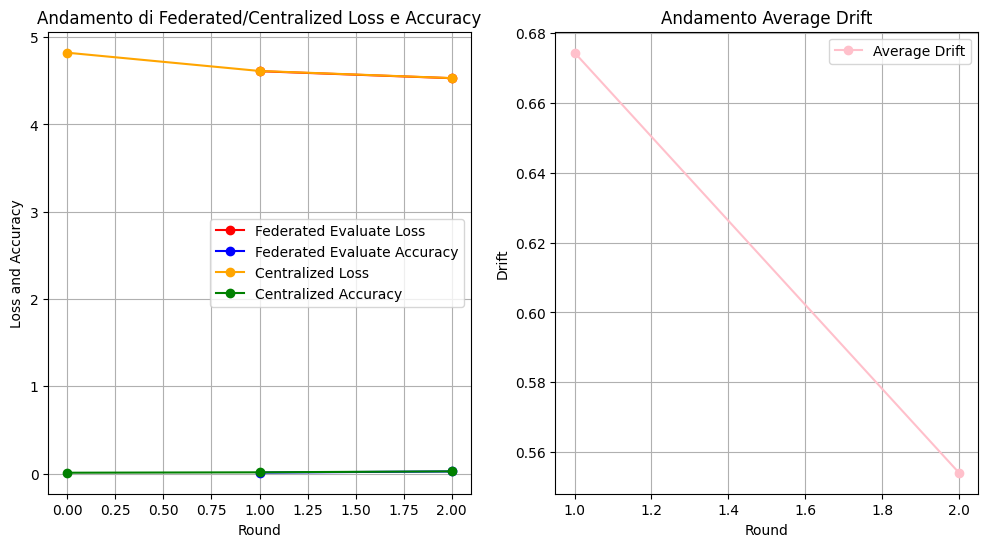

In [13]:
from fl_g13.fl_pytorch.datasets import plot_results

strategy = server_app._strategy
results = strategy.results
if results:
    print("Contenuto di results.json:", results)

plot_results(results)